In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
# import xgboost as xgb
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import *
from sklearn.metrics import *
import numpy as np
import pandas as pd
import warnings
# import optuna
# from scipy.stats import randint
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('./datasets/mushroom.csv')
df2 = pd.read_csv('./datasets/mushrooms.csv')

# rename columns
df2.rename(columns={'bruises':'ruises'}, inplace=True)

# df = pd.concat([df, df2], axis=0)
# df = pd.concat([df, df2], axis=0)

In [4]:
df.shape

(25986, 23)

In [5]:
df.head()

,class,cap-shape,cap-surface,cap-color,ruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,e,x,f,n,f,n,f,w,n,b,t,NaN,s,y,w,p,NaN,n,o,p,w,v,NaN
1,p,NaN,y,g,t,NaN,f,c,b,k,e,b,f,s,n,c,p,w,n,e,NaN,y,g
2,e,b,y,n,t,n,f,c,NaN,n,t,r,s,s,p,NaN,p,w,o,p,b,y,w
3,e,x,g,g,t,n,f,w,b,n,t,b,s,s,p,NaN,p,w,n,n,NaN,NaN,d
4,e,NaN,f,NaN,t,n,a,w,n,n,e,?,s,k,NaN,w,p,w,NaN,l,w,v,d


<AxesSubplot:>

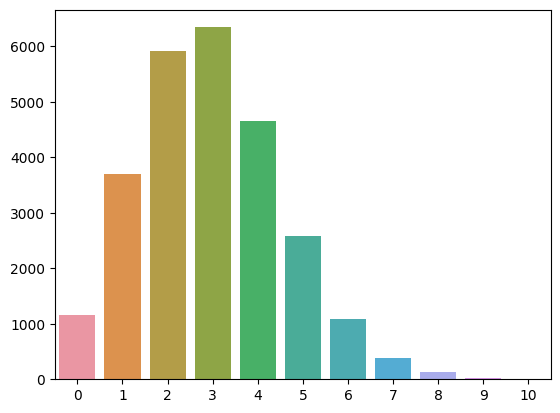

In [6]:
# print(data.describe())

# 统计所有行列中 NaN的个数的分布
distri = {}
for row in df.iterrows():
    cnt = 0
    for cell in row[1]:
        if str(cell) == 'nan':
            cnt += 1

    if cnt not in distri:
        distri[cnt] = 1
    distri[cnt] += 1


# 画图
sns.barplot(x=list(distri.keys()), y=list(distri.values()))

[0, 0.04440852766874471, 0.18675440621873315, 0.4143769722158085, 0.6585469098745478, 0.8376818286769798, 0.9369275763872854, 0.9790271684753328, 0.9938428384514738, 0.9989609789886862, 1.0001154467790347]


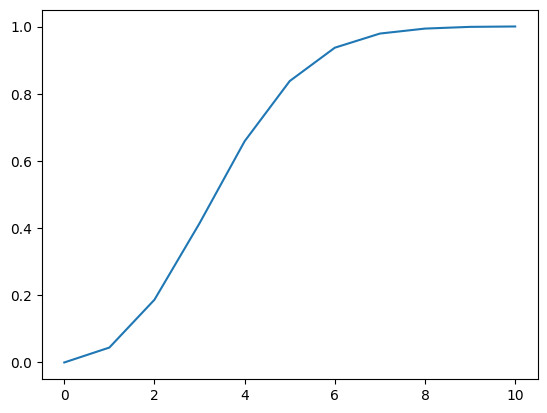

In [7]:
# 计算缺失值的比例
ratio = {}
for key in distri.keys():
    ratio[key] = distri[key] / df.shape[0]

sum_list = []
for i in range(0, len(ratio)):
    s = 0
    # 加上比i小的所有比例
    for j in range(0, i):
        s += ratio[j]
    sum_list.append(s)

# 画折线图
sns.lineplot(x=range(0, len(ratio) ), y=pd.Series(sum_list))
print(sum_list)


# find the last 97%
i = 0
while sum_list[i] < 0.97:
    i += 1

## 丢弃缺失值个数超过i 的行

In [8]:
# # 丢弃缺失值个数超过i 的行
# for row in df.iterrows():
#     cnt = 0
#     for cell in row[1]:
#         if str(cell) == 'nan':
#             cnt += 1
#     if cnt > i:
#         df.drop(row[0], inplace=True)

In [9]:
print(df.isna().sum().sum())
print(df.duplicated().sum())

76697
0


## 丢弃 veil-type

In [10]:
df.drop(columns = ['veil-type'], inplace = True)

## 编码插值

In [11]:
# # 用众数填充缺失值
# df = df.apply(lambda x: x.fillna(df.mode().iloc[0]))

# x = df.drop('class', axis=1)
# y = df['class']

# x = OneHotEncoder().fit_transform(x)
# y = LabelEncoder().fit_transform(y)

In [12]:
from sklearn.impute import KNNImputer
mask = df.isnull()
# class 使用 OneHotEncoder
df['class'] = OneHotEncoder().fit_transform(df['class'].values.reshape(-1, 1)).toarray()
# 其余使用 LabelEncoder 编码
for col in df.columns:
    if col != 'class':
        df[col] = LabelEncoder().fit_transform(df[col])

df.where(~mask, np.nan, inplace=True)

# KNN Imputer

df = pd.DataFrame(KNNImputer(
    n_neighbors=5).fit_transform(df), columns=df.columns)

df.head()

x = df.drop('class', axis=1)
y = df['class']

## 正态分析

In [13]:
# for feature in df.columns:
#     Q1 = df[feature].quantile(0.25)
#     Q3 = df[feature].quantile(0.75)
#     IQR = Q3 - Q1

# def outlier_treatment(colume_name) -> None:
#     global df
#     Q1, Q3 = df[colume_name].quantile([0.25, 0.75])
#     IQR = Q3 - Q1
    
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
    
#     outliers_iqr = df[(df[colume_name] < lower_bound) | (df[colume_name] > upper_bound)]
    
#     if outliers_iqr.empty:
#         print(f'No outliers found in {colume_name}')
#     else:
#         # drop
#         print(f'Outliers found in {colume_name}, dropping {outliers_iqr.shape[0]} rows')
#         df.drop(outliers_iqr.index, inplace=True)
#         df = df.reset_index(drop = True)

# for feature in df.columns:
#     outlier_treatment(feature)

# # ret = process_map(outlier_treatment, df.columns)

## 数据集划分

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(20788, 21) (20788,)
(5198, 21) (5198,)


## 模型训练

In [15]:
model_result = [
    
]
# {
#     'model': 'name',
#     'result': 'list'
# }

# f1 = make_scorer(f1_score, average='weighted')

### SVM - Baseline

In [16]:
# svm_model = SVC()
# svm_model.fit(x_train, y_train)

# svm_pred = svm_model.predict(x_test)

# model_result.append({
#     'model': 'SVM',
#     'result': svm_pred
# })

#### 测试结果

In [17]:
# ConfusionMatrixDisplay.from_predictions(y_test, svm_pred)
# plt.show()

# print(classification_report(y_test, svm_pred))

### SVM 贝叶斯优化

In [18]:
# def objective(trial):
#     C = trial.suggest_loguniform('C', 1e-3, 1e3)
#     gamma = trial.suggest_loguniform('gamma', 1e-3, 1e-1)
#     kernel = trial.suggest_categorical('kernel', ['rbf'])

#     svc = SVC(C=C, gamma=gamma, kernel=kernel)
    
#     # f1_score
#     score = cross_val_score(svc, x_train, y_train, cv=5, scoring=f1).mean()
#     return score

# study = optuna.create_study(direction='maximize')


In [19]:
# study.optimize(objective, n_trials=96, n_jobs=-1)

In [20]:
# # svm_model = SVC(C=study.best_params['C'], gamma=study.best_params['gamma'], kernel=study.best_params['kernel'])
# best = {'C': 0.17284149315658728, 'gamma': 0.0015771661832327244, 'kernel': 'rbf'}
# svm_model = SVC(C=best['C'], gamma=best['gamma'], kernel=best['kernel'])
# svm_model.fit(x_train, y_train)

# svm_pred = svm_model.predict(x_test)

# model_result.append({
#     'model': 'SVM',
#     'result': svm_pred
# })

#### 测试结果

In [21]:
# ConfusionMatrixDisplay.from_predictions(y_test, svm_pred)
# plt.show()

# print(classification_report(y_test, svm_pred))

### GradientBoostingClassifier

In [22]:
# gb_model = GradientBoostingClassifier()

# parameters = {
#     'n_estimators': np.arange(50, 500, 50),
#     'max_depth': np.arange(1, 10, 1),
#     'learning_rate': np.logspace(-3, 2, 10)
# }

# grid_search = GridSearchCV(gb_model, parameters, cv=5, n_jobs=-1, verbose=1)
# grid_search.fit(x_train, y_train)



In [23]:
# print(grid_search.best_params_)



In [24]:
# gb_model = GradientBoostingClassifier(**grid_search.best_params_)
# gb_model.fit(x_train, y_train)
 
# gb_pred = gb_model.predict(x_test)

# model_result.append({
#     'model': 'GradientBoosting',
#     'result': gb_pred
# })

#### 测试结果

In [25]:
# ConfusionMatrixDisplay.from_predictions(y_test, gb_pred)
# plt.show()

# print(classification_report(y_test, gb_pred))

### AdaBoostClassifier

In [26]:
# # ada_model = AdaBoostClassifier()

# # parameters = {
# #     'n_estimators': np.arange(50, 500, 20),
# #     'learning_rate': np.logspace(-3, 2, 20),
# #     'algorithm': ['SAMME']
# # }

# # grid_search = GridSearchCV(ada_model, parameters, n_jobs=-1, cv=5, verbose=1)
# # grid_search.fit(x_train, y_train)

# # ada_model = AdaBoostClassifier(n_estimators=grid_search.best_params_[
# #                                'n_estimators'], learning_rate=grid_search.best_params_['learning_rate'])

# best_params = {'algorithm': 'SAMME',
#                'learning_rate': 0.774263682681127, 'n_estimators': 150}

# ada_model = AdaBoostClassifier(
#     n_estimators=best_params['n_estimators'], learning_rate=best_params['learning_rate'], algorithm=best_params['algorithm'])

# ada_model.fit(x_train, y_train)

# ada_pred = ada_model.predict(x_test)

# model_result.append({
#     'model': 'AdaBoost',
#     'result': ada_pred
# })

In [27]:
# print(grid_search.best_params_)

In [28]:
# import joblib
# import time
# joblib.dump(ada_model, f'./results/ada_model_nodrop_{time.strftime("%Y-%m-%d-%H-%M-%S")}.pkl')

#### 测试结果

In [29]:
# ConfusionMatrixDisplay.from_predictions(y_test, ada_pred)
# plt.show()

# print(classification_report(y_test, ada_pred))

### LSTM

In [30]:
# # 长短期记忆网络 

# from keras.models import Sequential
# from keras.layers import Dense, LSTM

# model = Sequential()

# model.add(LSTM(128, input_shape=(x_train.shape[1], 1)))
# model.add(Dense(1, activation='sigmoid'))

# # metrics f1_score
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



In [31]:
# # with test
# model.fit(x_train, y_train, epochs=100, batch_size=256, validation_data=(x_test, y_test))

# lstm_pred = model.predict(x_test)

# model_result.append({
#     'model': 'LSTM',
#     'result': lstm_pred
# })

### RNN

In [32]:
# # RNN

# from keras.layers import SimpleRNN
# from keras.models import *
# from keras.layers import *

# rnn_model = Sequential()

# rnn_model.add(SimpleRNN(128, input_shape=(x_train.shape[1], 1)))
# rnn_model.add(Dense(1, activation='sigmoid'))

# rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
# rnn_model.fit(x_train, y_train, epochs=100, batch_size=256, validation_data=(x_test, y_test))

# rnn_pred = rnn_model.predict(x_test)

# model_result.append({
#     'model': 'RNN',
#     'result': rnn_pred
# })

### LightGBM

In [37]:
import lightgbm as lgb

train_data = lgb.Dataset(x_train, label=y_train)
test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

# 设置LightGBM参数
params = {'lambda_l1': 3.4482046572642613e-07, 'lambda_l2': 6.557494099284118e-06, 'num_leaves': 6,
          'feature_fraction': 0.9298593243367005, 'bagging_fraction': 0.6392974057353847, 'bagging_freq': 3}

# 训练模型
bst = lgb.train(params, train_data, num_boost_round=2000,
                valid_sets=[test_data])

# 预测
y_pred = bst.predict(x_test, num_iteration=bst.best_iteration)

# 二值化预测结果
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]


print(classification_report(y_test, y_pred_binary))

print(precision_score(y_test, y_pred_binary))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] Start training from score 0.552290
              precision    recall  f1-score   support

         0.0       0.73      0.69      0.71      2325
         1.0       0.76      0.79      0.78      2873

    accuracy                           0.75      5198
   macro avg       0.75      0.74      0.75      5198
weighted avg       0.75      0.75      0.75      5198

0.7621910487641951


In [36]:
# import optuna

# def objective(trial):
#     param = {
#         'objective': 'binary',
#         'metric': 'binary_logloss',
#         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
#         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
#         'num_leaves': trial.suggest_int('num_leaves', 2, 256),
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
#         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#         # 'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#     }

#     gbm = lgb.train(param, train_data)
#     preds = gbm.predict(x_test)
#     pred_labels = np.rint(preds)
#     accuracy = f1_score(y_test, pred_labels)
#     return accuracy

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

[I 2024-07-17 23:49:03,227] A new study created in memory with name: no-name-1b84cc53-45c9-400b-9d05-0ed9d7a5345c


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:49:07,453] Trial 0 finished with value: 0.7821765209940017 and parameters: {'lambda_l1': 0.3602330233147792, 'lambda_l2': 1.2686984609361715e-07, 'num_leaves': 126, 'feature_fraction': 0.772380593164173, 'bagging_fraction': 0.9017759432305135, 'bagging_freq': 7}. Best is trial 0 with value: 0.7821765209940017.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:49:12,415] Trial 1 finished with value: 0.7793233728318736 and parameters: {'lambda_l1': 8.797369941670623e-08, 'lambda_l2': 4.264177402397175e-06, 'num_leaves': 39, 'feature_fraction': 0.8941139333515628, 'bagging_fraction': 0.9665429117744112, 'bagging_freq': 5}. Best is trial 0 with value: 0.7821765209940017.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056237 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:49:17,239] Trial 2 finished with value: 0.7757762909589981 and parameters: {'lambda_l1': 0.008730380150846921, 'lambda_l2': 2.7691237292796256, 'num_leaves': 107, 'feature_fraction': 0.7364323377534521, 'bagging_fraction': 0.46570890405602994, 'bagging_freq': 5}. Best is trial 0 with value: 0.7821765209940017.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:49:51,202] Trial 3 finished with value: 0.7796204479398188 and parameters: {'lambda_l1': 1.1834295684625669e-06, 'lambda_l2': 0.005294628166483138, 'num_leaves': 252, 'feature_fraction': 0.7621091078657607, 'bagging_fraction': 0.8447573003543204, 'bagging_freq': 6}. Best is trial 0 with value: 0.7821765209940017.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:49:52,216] Trial 4 finished with value: 0.7829205807002563 and parameters: {'lambda_l1': 6.58108774882649e-06, 'lambda_l2': 2.2583944433009368e-05, 'num_leaves': 9, 'feature_fraction': 0.9560395471888771, 'bagging_fraction': 0.6465383772211833, 'bagging_freq': 3}. Best is trial 4 with value: 0.7829205807002563.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:50:01,225] Trial 5 finished with value: 0.7831881086622245 and parameters: {'lambda_l1': 2.0934316226006154e-07, 'lambda_l2': 4.352285305737986e-07, 'num_leaves': 17, 'feature_fraction': 0.7644667837181798, 'bagging_fraction': 0.9948712404412705, 'bagging_freq': 6}. Best is trial 5 with value: 0.7831881086622245.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:50:11,491] Trial 6 finished with value: 0.7773995915588836 and parameters: {'lambda_l1': 1.4367171701495487e-08, 'lambda_l2': 0.016499530835771346, 'num_leaves': 172, 'feature_fraction': 0.4452519535345722, 'bagging_fraction': 0.8623501327620557, 'bagging_freq': 5}. Best is trial 5 with value: 0.7831881086622245.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2024-07-17 23:50:41,126] Trial 7 finished with value: 0.7785996903492173 and parameters: {'lambda_l1': 0.019593008400691714, 'lambda_l2': 6.5305130216132214, 'num_leaves': 198, 'feature_fraction': 0.6833803986930795, 'bagging_fraction': 0.6678550984090019, 'bagging_freq': 3}. Best is trial 5 with value: 0.7831881086622245.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:51:05,545] Trial 8 finished with value: 0.7752309271296614 and parameters: {'lambda_l1': 0.00039903196927950084, 'lambda_l2': 0.00894728361609755, 'num_leaves': 198, 'feature_fraction': 0.4167743333453212, 'bagging_fraction': 0.8054359897780072, 'bagging_freq': 4}. Best is trial 5 with value: 0.7831881086622245.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:51:08,223] Trial 9 finished with value: 0.7789941840574751 and parameters: {'lambda_l1': 7.34551046130922e-06, 'lambda_l2': 0.00030895349925752036, 'num_leaves': 48, 'feature_fraction': 0.5745714758750772, 'bagging_fraction': 0.49157546870753543, 'bagging_freq': 3}. Best is trial 5 with value: 0.7831881086622245.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:51:34,716] Trial 10 finished with value: 0.7816406918992977 and parameters: {'lambda_l1': 0.00014009738245197625, 'lambda_l2': 1.0657652629541758e-08, 'num_leaves': 81, 'feature_fraction': 0.6223348283804455, 'bagging_fraction': 0.7470607929022159, 'bagging_freq': 1}. Best is trial 5 with value: 0.7831881086622245.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:51:35,763] Trial 11 finished with value: 0.7858967807869188 and parameters: {'lambda_l1': 1.8458088137239206e-06, 'lambda_l2': 9.251826842882609e-06, 'num_leaves': 8, 'feature_fraction': 0.9426425941101728, 'bagging_fraction': 0.6104320766695679, 'bagging_freq': 1}. Best is trial 11 with value: 0.7858967807869188.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:51:38,057] Trial 12 finished with value: 0.7848966342046814 and parameters: {'lambda_l1': 2.4861523253852033e-07, 'lambda_l2': 1.0541449362822703e-06, 'num_leaves': 15, 'feature_fraction': 0.857693925229214, 'bagging_fraction': 0.5636691501144313, 'bagging_freq': 1}. Best is trial 11 with value: 0.7858967807869188.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:51:43,749] Trial 13 finished with value: 0.7768225584594224 and parameters: {'lambda_l1': 6.470093244705857e-05, 'lambda_l2': 3.6015440095263434e-05, 'num_leaves': 71, 'feature_fraction': 0.8707356353361102, 'bagging_fraction': 0.5730663676784941, 'bagging_freq': 1}. Best is trial 11 with value: 0.7858967807869188.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:51:44,607] Trial 14 finished with value: 0.7832001360312871 and parameters: {'lambda_l1': 1.2265953797707903e-08, 'lambda_l2': 6.607105618607518e-07, 'num_leaves': 5, 'feature_fraction': 0.9871282913296264, 'bagging_fraction': 0.5427446409749462, 'bagging_freq': 2}. Best is trial 11 with value: 0.7858967807869188.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:52:02,647] Trial 15 finished with value: 0.77863116572794 and parameters: {'lambda_l1': 2.6728287194708514e-06, 'lambda_l2': 1.0284227637239189e-08, 'num_leaves': 56, 'feature_fraction': 0.8609500858914378, 'bagging_fraction': 0.5988545884677857, 'bagging_freq': 1}. Best is trial 11 with value: 0.7858967807869188.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2024-07-17 23:52:10,334] Trial 16 finished with value: 0.7766856354543886 and parameters: {'lambda_l1': 8.584054470959488, 'lambda_l2': 0.0001001803118236565, 'num_leaves': 102, 'feature_fraction': 0.9257459404940401, 'bagging_fraction': 0.42084949048927933, 'bagging_freq': 2}. Best is trial 11 with value: 0.7858967807869188.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:52:11,992] Trial 17 finished with value: 0.7797945205479452 and parameters: {'lambda_l1': 2.3340315128291425e-07, 'lambda_l2': 6.4125323362191575e-06, 'num_leaves': 27, 'feature_fraction': 0.8284855231687334, 'bagging_fraction': 0.737895576853778, 'bagging_freq': 2}. Best is trial 11 with value: 0.7858967807869188.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:52:33,064] Trial 18 finished with value: 0.7754681326232606 and parameters: {'lambda_l1': 0.0015192385416000443, 'lambda_l2': 0.0016953874487548014, 'num_leaves': 159, 'feature_fraction': 0.9968285594819896, 'bagging_fraction': 0.6145340741846951, 'bagging_freq': 1}. Best is trial 11 with value: 0.7858967807869188.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:52:57,115] Trial 19 finished with value: 0.7778735136998104 and parameters: {'lambda_l1': 3.131930250327496e-05, 'lambda_l2': 0.2787052231301742, 'num_leaves': 76, 'feature_fraction': 0.8213500009560317, 'bagging_fraction': 0.5202099605808419, 'bagging_freq': 2}. Best is trial 11 with value: 0.7858967807869188.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:53:02,840] Trial 20 finished with value: 0.7828913601368691 and parameters: {'lambda_l1': 7.131280828012655e-07, 'lambda_l2': 1.1027547335433545e-07, 'num_leaves': 36, 'feature_fraction': 0.9251522583619993, 'bagging_fraction': 0.7208613967916795, 'bagging_freq': 4}. Best is trial 11 with value: 0.7858967807869188.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:53:06,912] Trial 21 finished with value: 0.7824303537856777 and parameters: {'lambda_l1': 1.313916943791495e-08, 'lambda_l2': 1.2227615701683678e-06, 'num_leaves': 5, 'feature_fraction': 0.9858174691787568, 'bagging_fraction': 0.5481976871335422, 'bagging_freq': 2}. Best is trial 11 with value: 0.7858967807869188.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:53:08,198] Trial 22 finished with value: 0.787284409874873 and parameters: {'lambda_l1': 3.960352937811111e-08, 'lambda_l2': 1.4057568372329893e-06, 'num_leaves': 4, 'feature_fraction': 0.9357246023942905, 'bagging_fraction': 0.40596178610994826, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:53:18,893] Trial 23 finished with value: 0.7774725274725275 and parameters: {'lambda_l1': 5.7489989904472806e-08, 'lambda_l2': 2.7351853538130477e-06, 'num_leaves': 52, 'feature_fraction': 0.9244316258986625, 'bagging_fraction': 0.4274799152106838, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:53:22,490] Trial 24 finished with value: 0.7777206512425022 and parameters: {'lambda_l1': 1.510722338422316e-05, 'lambda_l2': 1.351710352847491e-05, 'num_leaves': 27, 'feature_fraction': 0.8261421580236766, 'bagging_fraction': 0.4727883941801232, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:53:24,536] Trial 25 finished with value: 0.7736256435808005 and parameters: {'lambda_l1': 7.235816317230481e-07, 'lambda_l2': 1.7270423784744299e-07, 'num_leaves': 2, 'feature_fraction': 0.8829365296531961, 'bagging_fraction': 0.6415419326897862, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:53:26,898] Trial 26 finished with value: 0.7776826972445661 and parameters: {'lambda_l1': 9.15879624042074e-08, 'lambda_l2': 0.00015891504706814772, 'num_leaves': 60, 'feature_fraction': 0.6803414676316907, 'bagging_fraction': 0.40562182546197095, 'bagging_freq': 3}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.071650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:53:30,763] Trial 27 finished with value: 0.7777015437392796 and parameters: {'lambda_l1': 2.372132532255354e-06, 'lambda_l2': 4.958622406434735e-08, 'num_leaves': 97, 'feature_fraction': 0.9393873656697741, 'bagging_fraction': 0.5116617348688177, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.076690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:53:52,111] Trial 28 finished with value: 0.7812126387702819 and parameters: {'lambda_l1': 3.9757087465532234e-08, 'lambda_l2': 0.000953030057829318, 'num_leaves': 27, 'feature_fraction': 0.5154535249173466, 'bagging_fraction': 0.6847290786270115, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:54:03,179] Trial 29 finished with value: 0.768729641693811 and parameters: {'lambda_l1': 4.1042074854948574e-07, 'lambda_l2': 5.592690716925183e-05, 'num_leaves': 135, 'feature_fraction': 0.8103905624238568, 'bagging_fraction': 0.5831416786214585, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:54:12,583] Trial 30 finished with value: 0.7830253251197811 and parameters: {'lambda_l1': 0.0004929567129336858, 'lambda_l2': 9.81739527948266e-07, 'num_leaves': 25, 'feature_fraction': 0.7192296826458278, 'bagging_fraction': 0.7902401186342621, 'bagging_freq': 7}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:54:13,990] Trial 31 finished with value: 0.7834665759482906 and parameters: {'lambda_l1': 1.085067838847724e-08, 'lambda_l2': 3.803343124583001e-07, 'num_leaves': 4, 'feature_fraction': 0.9749771568454036, 'bagging_fraction': 0.5438232509434774, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:54:15,577] Trial 32 finished with value: 0.7791274593669802 and parameters: {'lambda_l1': 4.7401210437592986e-08, 'lambda_l2': 4.758076052486901e-06, 'num_leaves': 44, 'feature_fraction': 0.9639744808226376, 'bagging_fraction': 0.5549224204342003, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:54:17,893] Trial 33 finished with value: 0.7807137954701441 and parameters: {'lambda_l1': 1.1263960095706287e-07, 'lambda_l2': 4.572023994550167e-08, 'num_leaves': 17, 'feature_fraction': 0.9032233148503072, 'bagging_fraction': 0.4545179360159222, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:54:21,699] Trial 34 finished with value: 0.7838715188792073 and parameters: {'lambda_l1': 3.4485523334446326e-08, 'lambda_l2': 3.053608792721518e-07, 'num_leaves': 38, 'feature_fraction': 0.8566768314432274, 'bagging_fraction': 0.6368511683031488, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:54:24,620] Trial 35 finished with value: 0.777319587628866 and parameters: {'lambda_l1': 4.069025633005754e-07, 'lambda_l2': 2.392080895736374e-06, 'num_leaves': 35, 'feature_fraction': 0.7944012464664094, 'bagging_fraction': 0.6160290288924299, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:54:50,659] Trial 36 finished with value: 0.772999828679116 and parameters: {'lambda_l1': 2.057167940574201e-06, 'lambda_l2': 1.2751732343197746e-05, 'num_leaves': 251, 'feature_fraction': 0.8519683981830897, 'bagging_fraction': 0.6579493560190817, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:55:00,343] Trial 37 finished with value: 0.7763567231247839 and parameters: {'lambda_l1': 3.620383786823371e-08, 'lambda_l2': 9.913032959282872e-08, 'num_leaves': 125, 'feature_fraction': 0.8936801783944738, 'bagging_fraction': 0.6312533040961303, 'bagging_freq': 3}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:55:16,864] Trial 38 finished with value: 0.7807137954701441 and parameters: {'lambda_l1': 1.8158825668556073e-07, 'lambda_l2': 2.684344190433838e-07, 'num_leaves': 19, 'feature_fraction': 0.7904338744159557, 'bagging_fraction': 0.709668496698345, 'bagging_freq': 6}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:55:21,653] Trial 39 finished with value: 0.7734711455641688 and parameters: {'lambda_l1': 6.319402043477036e-06, 'lambda_l2': 1.4968756941649295e-06, 'num_leaves': 66, 'feature_fraction': 0.7408274020791491, 'bagging_fraction': 0.9297536617644018, 'bagging_freq': 3}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:55:45,256] Trial 40 finished with value: 0.7747130375192736 and parameters: {'lambda_l1': 0.005365960689160496, 'lambda_l2': 1.2337299013762176e-05, 'num_leaves': 92, 'feature_fraction': 0.9520259519029403, 'bagging_fraction': 0.4510037301959625, 'bagging_freq': 4}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:55:46,080] Trial 41 finished with value: 0.7832024581768522 and parameters: {'lambda_l1': 2.4877974324292653e-08, 'lambda_l2': 3.439349988050258e-08, 'num_leaves': 11, 'feature_fraction': 0.8979219113210589, 'bagging_fraction': 0.5120448238338666, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:55:50,132] Trial 42 finished with value: 0.779591135543721 and parameters: {'lambda_l1': 1.0232104118197074e-08, 'lambda_l2': 2.6557917190992804e-07, 'num_leaves': 39, 'feature_fraction': 0.9728770242214974, 'bagging_fraction': 0.5789254892207839, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:55:55,005] Trial 43 finished with value: 0.7829510441629579 and parameters: {'lambda_l1': 1.435161679401174e-07, 'lambda_l2': 9.462549189025443e-07, 'num_leaves': 16, 'feature_fraction': 0.854800456765239, 'bagging_fraction': 0.6792598284443894, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:55:55,638] Trial 44 finished with value: 0.7841394633395999 and parameters: {'lambda_l1': 0.12543313045066823, 'lambda_l2': 4.3790779209504744e-07, 'num_leaves': 5, 'feature_fraction': 0.944875249235211, 'bagging_fraction': 0.49441878647842785, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:56:14,629] Trial 45 finished with value: 0.7799280698749785 and parameters: {'lambda_l1': 0.21412386786728915, 'lambda_l2': 5.959501881248335e-06, 'num_leaves': 45, 'feature_fraction': 0.9086966723732053, 'bagging_fraction': 0.4797871130041158, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:56:16,987] Trial 46 finished with value: 0.7822802197802198 and parameters: {'lambda_l1': 0.14789537668984268, 'lambda_l2': 5.356066171152295e-07, 'num_leaves': 14, 'feature_fraction': 0.9433220451696501, 'bagging_fraction': 0.4384557534416361, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:56:19,151] Trial 47 finished with value: 0.7807303274472828 and parameters: {'lambda_l1': 0.6822872602994846, 'lambda_l2': 2.691630918716283e-08, 'num_leaves': 35, 'feature_fraction': 0.8691263822547934, 'bagging_fraction': 0.4996719130732066, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:56:22,787] Trial 48 finished with value: 0.7726081258191351 and parameters: {'lambda_l1': 9.930066497710238, 'lambda_l2': 0.08813639202866776, 'num_leaves': 2, 'feature_fraction': 0.7807366486375357, 'bagging_fraction': 0.6153337580457046, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:56:40,717] Trial 49 finished with value: 0.7814319972593353 and parameters: {'lambda_l1': 0.014591552940616918, 'lambda_l2': 2.6328197124871476e-05, 'num_leaves': 24, 'feature_fraction': 0.6274655767349525, 'bagging_fraction': 0.5661964183407958, 'bagging_freq': 3}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:56:45,261] Trial 50 finished with value: 0.7797016972398423 and parameters: {'lambda_l1': 1.1905124833383725, 'lambda_l2': 2.448809155930321e-06, 'num_leaves': 86, 'feature_fraction': 0.8426352157689012, 'bagging_fraction': 0.5341862846318628, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:56:46,548] Trial 51 finished with value: 0.7830107895187531 and parameters: {'lambda_l1': 0.04643585836882674, 'lambda_l2': 3.9190781107282135e-07, 'num_leaves': 12, 'feature_fraction': 0.9629670727992216, 'bagging_fraction': 0.4901275615113315, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:56:50,307] Trial 52 finished with value: 0.7746409113422487 and parameters: {'lambda_l1': 2.7765895669398976e-08, 'lambda_l2': 1.0362877233192058e-07, 'num_leaves': 2, 'feature_fraction': 0.9951152484551505, 'bagging_fraction': 0.5986525439963031, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:57:07,939] Trial 53 finished with value: 0.781287348471914 and parameters: {'lambda_l1': 3.407425315892697e-07, 'lambda_l2': 5.522819821402037e-07, 'num_leaves': 31, 'feature_fraction': 0.9195162921280116, 'bagging_fraction': 0.5369603595518273, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.086679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:57:13,166] Trial 54 finished with value: 0.771438332763922 and parameters: {'lambda_l1': 1.0967461471870433e-06, 'lambda_l2': 1.936914854810931e-07, 'num_leaves': 57, 'feature_fraction': 0.9401374898876508, 'bagging_fraction': 0.405528263308202, 'bagging_freq': 5}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:57:15,108] Trial 55 finished with value: 0.7811965811965812 and parameters: {'lambda_l1': 7.338335864188616e-08, 'lambda_l2': 1.9715286008052378e-08, 'num_leaves': 13, 'feature_fraction': 0.8793023095800804, 'bagging_fraction': 0.5955999322743902, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:57:20,603] Trial 56 finished with value: 0.7800376004101863 and parameters: {'lambda_l1': 2.0407032485641085e-08, 'lambda_l2': 1.740604243352818e-06, 'num_leaves': 47, 'feature_fraction': 0.9731699092842767, 'bagging_fraction': 0.6353888165185937, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:57:37,901] Trial 57 finished with value: 0.7810529902879536 and parameters: {'lambda_l1': 0.00011533868589507492, 'lambda_l2': 7.05039227953608e-08, 'num_leaves': 21, 'feature_fraction': 0.9295988808032378, 'bagging_fraction': 0.5264580970761545, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:57:47,693] Trial 58 finished with value: 0.7685201026518392 and parameters: {'lambda_l1': 0.0013323821453342457, 'lambda_l2': 7.0677368740100634e-06, 'num_leaves': 209, 'feature_fraction': 0.958207546615947, 'bagging_fraction': 0.46817612052522484, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:58:03,323] Trial 59 finished with value: 0.7834699453551912 and parameters: {'lambda_l1': 9.558463489564048e-06, 'lambda_l2': 6.442097801879512e-07, 'num_leaves': 10, 'feature_fraction': 0.8821215292446293, 'bagging_fraction': 0.7633005907229778, 'bagging_freq': 3}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:58:09,605] Trial 60 finished with value: 0.7764220656470184 and parameters: {'lambda_l1': 1.716185708641245e-05, 'lambda_l2': 4.292063960943329e-05, 'num_leaves': 69, 'feature_fraction': 0.7491893703268683, 'bagging_fraction': 0.7417589611077269, 'bagging_freq': 3}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:58:10,379] Trial 61 finished with value: 0.7800136425648021 and parameters: {'lambda_l1': 4.810450062080489e-06, 'lambda_l2': 6.979025019244418e-07, 'num_leaves': 9, 'feature_fraction': 0.8868014862321877, 'bagging_fraction': 0.7726178118316527, 'bagging_freq': 4}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:58:14,911] Trial 62 finished with value: 0.7729676140118968 and parameters: {'lambda_l1': 9.170013023509763e-07, 'lambda_l2': 3.1709406736984574e-07, 'num_leaves': 2, 'feature_fraction': 0.9988752373293969, 'bagging_fraction': 0.8657996439112674, 'bagging_freq': 3}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:58:33,334] Trial 63 finished with value: 0.781565872879904 and parameters: {'lambda_l1': 2.441797880428963e-07, 'lambda_l2': 3.728422235842384e-06, 'num_leaves': 21, 'feature_fraction': 0.910144947458077, 'bagging_fraction': 0.8341408923852035, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:58:37,001] Trial 64 finished with value: 0.7772073921971252 and parameters: {'lambda_l1': 3.215875505095308, 'lambda_l2': 1.5200112685014277e-07, 'num_leaves': 31, 'feature_fraction': 0.8134175609244937, 'bagging_fraction': 0.5674968121548711, 'bagging_freq': 4}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:58:38,443] Trial 65 finished with value: 0.7846759021720541 and parameters: {'lambda_l1': 9.363181055180053e-08, 'lambda_l2': 1.0159156091105864e-06, 'num_leaves': 10, 'feature_fraction': 0.8346948856313913, 'bagging_fraction': 0.6963565980261525, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:59:01,821] Trial 66 finished with value: 0.7772641670946756 and parameters: {'lambda_l1': 4.991548605061184e-07, 'lambda_l2': 1.2123024571271474e-06, 'num_leaves': 42, 'feature_fraction': 0.8476029633525047, 'bagging_fraction': 0.7673315552495882, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:59:04,507] Trial 67 finished with value: 0.780229177355909 and parameters: {'lambda_l1': 3.045973816934975e-06, 'lambda_l2': 0.00010588914104671332, 'num_leaves': 25, 'feature_fraction': 0.8286303159316852, 'bagging_fraction': 0.6945260561926897, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:59:05,602] Trial 68 finished with value: 0.7860425531914895 and parameters: {'lambda_l1': 8.403274807092867e-08, 'lambda_l2': 1.0330237340696673e-05, 'num_leaves': 10, 'feature_fraction': 0.8717044254272769, 'bagging_fraction': 0.6533274447536646, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.080467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:59:29,554] Trial 69 finished with value: 0.7793008910212474 and parameters: {'lambda_l1': 1.2769746483152483e-07, 'lambda_l2': 0.00037382240276440933, 'num_leaves': 37, 'feature_fraction': 0.8648380208337934, 'bagging_fraction': 0.6656125381695668, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.083337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:59:40,418] Trial 70 finished with value: 0.7748798901853123 and parameters: {'lambda_l1': 6.36592945325734e-08, 'lambda_l2': 8.744631912674759e-06, 'num_leaves': 110, 'feature_fraction': 0.8029748452384582, 'bagging_fraction': 0.7161913738074619, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-17 23:59:58,327] Trial 71 finished with value: 0.781855249745158 and parameters: {'lambda_l1': 4.2636653643158117e-05, 'lambda_l2': 2.727187908235324e-06, 'num_leaves': 9, 'feature_fraction': 0.8382473895607108, 'bagging_fraction': 0.6476991112724213, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:00:02,166] Trial 72 finished with value: 0.784313725490196 and parameters: {'lambda_l1': 1.5510271791247822e-06, 'lambda_l2': 2.1573418140866965e-05, 'num_leaves': 19, 'feature_fraction': 0.8762423738738191, 'bagging_fraction': 0.6745484288231527, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:00:09,002] Trial 73 finished with value: 0.78259385665529 and parameters: {'lambda_l1': 2.357695084233657e-07, 'lambda_l2': 1.9973364140423042e-05, 'num_leaves': 17, 'feature_fraction': 0.7640220656877096, 'bagging_fraction': 0.676150650594716, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:00:16,554] Trial 74 finished with value: 0.7763857902865968 and parameters: {'lambda_l1': 1.3322915280836993e-06, 'lambda_l2': 1.9000263278941174e-05, 'num_leaves': 28, 'feature_fraction': 0.9080959869789295, 'bagging_fraction': 0.6986053295729224, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.221282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:00:27,971] Trial 75 finished with value: 0.7839972527472526 and parameters: {'lambda_l1': 7.328990775989937e-08, 'lambda_l2': 4.36203270350139e-06, 'num_leaves': 51, 'feature_fraction': 0.8665156708225793, 'bagging_fraction': 0.6231015535207266, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:00:53,223] Trial 76 finished with value: 0.7751458976999658 and parameters: {'lambda_l1': 8.460054767093618e-08, 'lambda_l2': 4.959798723407663e-06, 'num_leaves': 51, 'feature_fraction': 0.9194369785009986, 'bagging_fraction': 0.6185807962997604, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:00:59,231] Trial 77 finished with value: 0.780962128966223 and parameters: {'lambda_l1': 6.081467759846068e-07, 'lambda_l2': 7.642385659625162e-05, 'num_leaves': 21, 'feature_fraction': 0.9425208346199326, 'bagging_fraction': 0.6607480787667908, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:01:20,362] Trial 78 finished with value: 0.7795505232458397 and parameters: {'lambda_l1': 1.7298150270085262e-08, 'lambda_l2': 9.763163386695621e-06, 'num_leaves': 61, 'feature_fraction': 0.8930351284564287, 'bagging_fraction': 0.6240619552306716, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:01:51,085] Trial 79 finished with value: 0.7754193769257104 and parameters: {'lambda_l1': 5.0702365914337676e-08, 'lambda_l2': 0.0001779348970508537, 'num_leaves': 161, 'feature_fraction': 0.5196193637553858, 'bagging_fraction': 0.5973896974824586, 'bagging_freq': 1}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:01:54,971] Trial 80 finished with value: 0.7860560492139439 and parameters: {'lambda_l1': 1.461264896104747e-06, 'lambda_l2': 1.6232155972861276e-06, 'num_leaves': 8, 'feature_fraction': 0.8721507382128245, 'bagging_fraction': 0.6482340667029309, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:01:59,148] Trial 81 finished with value: 0.7854334074200718 and parameters: {'lambda_l1': 1.881894943594622e-06, 'lambda_l2': 1.689874702559035e-06, 'num_leaves': 7, 'feature_fraction': 0.8756604398298689, 'bagging_fraction': 0.6490714602100769, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.074023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:02:00,004] Trial 82 finished with value: 0.7862868838478594 and parameters: {'lambda_l1': 1.7256798044689291e-06, 'lambda_l2': 1.163771621826e-06, 'num_leaves': 9, 'feature_fraction': 0.8353073998326047, 'bagging_fraction': 0.6542939107047974, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:02:17,659] Trial 83 finished with value: 0.7817622950819673 and parameters: {'lambda_l1': 1.7994176197387831e-06, 'lambda_l2': 1.7736744844850833e-06, 'num_leaves': 17, 'feature_fraction': 0.8211148234321233, 'bagging_fraction': 0.729883952653518, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:02:20,372] Trial 84 finished with value: 0.7848101265822786 and parameters: {'lambda_l1': 3.6006220836911997e-06, 'lambda_l2': 1.0770952907987507e-06, 'num_leaves': 8, 'feature_fraction': 0.8351727987080324, 'bagging_fraction': 0.6479108565263029, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:02:22,389] Trial 85 finished with value: 0.7842869342442358 and parameters: {'lambda_l1': 3.925860448307523e-06, 'lambda_l2': 9.966456338218722e-07, 'num_leaves': 8, 'feature_fraction': 0.7132611984228483, 'bagging_fraction': 0.6533610314603553, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:02:45,260] Trial 86 finished with value: 0.7789799072642968 and parameters: {'lambda_l1': 1.8075806177241167e-05, 'lambda_l2': 3.139514428192302e-06, 'num_leaves': 30, 'feature_fraction': 0.8312801672283558, 'bagging_fraction': 0.6848049889515938, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:02:50,410] Trial 87 finished with value: 0.7806551191905334 and parameters: {'lambda_l1': 9.804970287361108e-06, 'lambda_l2': 1.7930369993059429e-06, 'num_leaves': 12, 'feature_fraction': 0.8090407221991502, 'bagging_fraction': 0.6441763453716542, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:02:51,286] Trial 88 finished with value: 0.7850467289719626 and parameters: {'lambda_l1': 3.508020252537404e-07, 'lambda_l2': 8.054751956898838e-07, 'num_leaves': 8, 'feature_fraction': 0.7898856368892591, 'bagging_fraction': 0.7078363252616564, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:03:10,119] Trial 89 finished with value: 0.7843137254901961 and parameters: {'lambda_l1': 3.193242342349758e-07, 'lambda_l2': 6.044987305034324, 'num_leaves': 32, 'feature_fraction': 0.7878059292684477, 'bagging_fraction': 0.585294384366157, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:03:11,120] Trial 90 finished with value: 0.7672600232906339 and parameters: {'lambda_l1': 7.674287786388874e-07, 'lambda_l2': 1.932540223290328e-07, 'num_leaves': 2, 'feature_fraction': 0.6601552604806119, 'bagging_fraction': 0.7089774849644522, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:03:13,447] Trial 91 finished with value: 0.7816997943797123 and parameters: {'lambda_l1': 1.7144774830506908e-07, 'lambda_l2': 9.185902065222506e-07, 'num_leaves': 14, 'feature_fraction': 0.8440636208016413, 'bagging_fraction': 0.6905398637856978, 'bagging_freq': 3}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:03:15,377] Trial 92 finished with value: 0.7824303537856777 and parameters: {'lambda_l1': 2.837102986689292e-06, 'lambda_l2': 1.384929464758262e-06, 'num_leaves': 8, 'feature_fraction': 0.7709323825630732, 'bagging_fraction': 0.6647318685194161, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:03:18,552] Trial 93 finished with value: 0.7825196312734721 and parameters: {'lambda_l1': 5.886008538681126e-07, 'lambda_l2': 2.2830355996423776e-06, 'num_leaves': 26, 'feature_fraction': 0.8588624005690707, 'bagging_fraction': 0.7033269506674107, 'bagging_freq': 7}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:03:23,178] Trial 94 finished with value: 0.7836818649297225 and parameters: {'lambda_l1': 1.1052071059087303e-06, 'lambda_l2': 7.164810940563319e-07, 'num_leaves': 22, 'feature_fraction': 0.7970231576341632, 'bagging_fraction': 0.7234784610506606, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:03:24,515] Trial 95 finished with value: 0.7850212765957446 and parameters: {'lambda_l1': 1.351032476593488e-07, 'lambda_l2': 5.809459613190575e-06, 'num_leaves': 7, 'feature_fraction': 0.893624918556124, 'bagging_fraction': 0.6085451338371857, 'bagging_freq': 2}. Best is trial 22 with value: 0.787284409874873.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:03:42,138] Trial 96 finished with value: 0.7878685191460522 and parameters: {'lambda_l1': 3.4482046572642613e-07, 'lambda_l2': 6.557494099284118e-06, 'num_leaves': 6, 'feature_fraction': 0.9298593243367005, 'bagging_fraction': 0.6392974057353847, 'bagging_freq': 3}. Best is trial 96 with value: 0.7878685191460522.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.079055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:03:51,123] Trial 97 finished with value: 0.7825046984452417 and parameters: {'lambda_l1': 2.8480368946696534e-07, 'lambda_l2': 3.530254891812464e-05, 'num_leaves': 16, 'feature_fraction': 0.9287358842540062, 'bagging_fraction': 0.6111257927280047, 'bagging_freq': 3}. Best is trial 96 with value: 0.7878685191460522.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:03:52,484] Trial 98 finished with value: 0.7718775847808106 and parameters: {'lambda_l1': 1.2663829013467895e-07, 'lambda_l2': 6.494007876133363e-06, 'num_leaves': 2, 'feature_fraction': 0.8985551033448742, 'bagging_fraction': 0.5595841743985195, 'bagging_freq': 3}. Best is trial 96 with value: 0.7878685191460522.


[LightGBM] [Info] Number of positive: 11481, number of negative: 9307
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.070468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 20788, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552290 -> initscore=0.209927
[LightGBM] [Info] Start training from score 0.209927


[I 2024-07-18 00:04:46,841] Trial 99 finished with value: 0.7755597986460685 and parameters: {'lambda_l1': 3.962081591055929e-07, 'lambda_l2': 1.147039870372715e-05, 'num_leaves': 190, 'feature_fraction': 0.9177125666377189, 'bagging_fraction': 0.6326337674136286, 'bagging_freq': 2}. Best is trial 96 with value: 0.7878685191460522.


Number of finished trials: 100
Best trial: {'lambda_l1': 3.4482046572642613e-07, 'lambda_l2': 6.557494099284118e-06, 'num_leaves': 6, 'feature_fraction': 0.9298593243367005, 'bagging_fraction': 0.6392974057353847, 'bagging_freq': 3}


## 模型对比

In [ ]:
# name = [i.get('model') for i in model_result]
# results = [i.get('result') for i in model_result]


# accuracy = [accuracy_score(y_test, i) for i in results]
# precision = [precision_score(y_test, i) for i in results]
# recall = [recall_score(y_test, i) for i in results]
# f1 = [f1_score(y_test, i) for i in results]
# auc = [roc_auc_score(y_test, i) for i in results]

# table = pd.DataFrame({
#     'name': name,
#     'f1': f1,
#     'accuracy': accuracy,
#     'precision': precision,
#     'recall': recall,
#     'auc': auc
# })

# # sort by accuracy
# table = table.sort_values(by='f1', ascending=False)

# print(table)


In [ ]:
# import pathlib
# import joblib

# df = pd.read_csv('./datasets/mushroom.csv')
# df2 = pd.read_csv('./datasets/mushrooms.csv')

# # rename columns
# df2.rename(columns={'bruises':'ruises'}, inplace=True)

# # df = pd.concat([df, df2], axis=0)
# # df = pd.concat([df, df2], axis=0)

# df.drop(columns = ['veil-type'], inplace = True)

# from sklearn.impute import KNNImputer
# mask = df.isnull()
# # class 使用 OneHotEncoder
# df['class'] = OneHotEncoder().fit_transform(df['class'].values.reshape(-1, 1)).toarray()
# # 其余使用 LabelEncoder 编码
# for col in df.columns:
#     if col != 'class':
#         df[col] = LabelEncoder().fit_transform(df[col])

# df.where(~mask, np.nan, inplace=True)

# # KNN Imputer
# df = pd.DataFrame(KNNImputer(
#     n_neighbors=5).fit_transform(df), columns=df.columns)

# df.head()

# x = df.drop('class', axis=1)
# y = df['class']

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
# print(x_train.shape, y_train.shape)
# print(x_test.shape, y_test.shape)

# name = []
# accuracy = []
# precision = []
# recall = []
# f1 = []
# auc = []

# for path in pathlib.Path('./results').glob('*.pkl'):
#     try:
#         model = joblib.load(path)
#         pred = model.predict(x_test)
        
#         name.append(path.stem)
#         accuracy.append(accuracy_score(y_test, pred))
#         precision.append(precision_score(y_test, pred))
#         recall.append(recall_score(y_test, pred))
#         f1.append(f1_score(y_test, pred))
#         auc.append(roc_auc_score(y_test, pred))
#     except Exception as e:
#         print(path)

# print(pd.DataFrame({
#     'name': name,
#     'f1': f1,
#     'accuracy': accuracy,
#     'precision': precision,
#     'recall': recall,
#     'auc': auc
# }))